In [37]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import winsound
import sounddevice as sd
import pandas as pd
from scipy import signal
from scipy.fftpack import fft, fftshift
import peakutils
import soundfile   as sf

In [38]:
def calcFFT(signal, fs):
    # https://docs.scipy.org/doc/scipy/reference/tutorial/fftpack.html
    #y  = np.append(signal, np.zeros(len(signal)*fs))
    N  = len(signal)
    T  = 1/fs
    xf = np.linspace(-1.0/(2.0*T), 1.0/(2.0*T), N)
    yf = fft(signal)
    return(xf, fftshift(yf))

In [39]:
def generateSin(freq, time, fs):
    n = time*fs #numero de pontos
    x = np.linspace(0.0, time, n)  # eixo do tempo
    s = np.sin(freq*x*2*np.pi)
    return (x, s)

In [40]:
def plotFFT(signal, fs):
    x,y = calcFFT(signal, fs)
    plt.figure()
    plt.plot(x, np.abs(y))
    plt.title('Fourier')
    plt.show()
    return x,y

In [88]:
digitos_dict = {}
digitos_dict["Frequencia"] = [697, 770, 852, 941]
digitos_dict[1209] = [1, 4, 7, "X"]
digitos_dict[1336] = [2, 5, 8, "0"]
digitos_dict[1477] = [3, 6, 9, "#"]
digitos_dict[1633] = ["A", "B", "C", "D"]


def get_line(freq):
    return_freq = False
    check = True
    list_1 = [697, 770, 852, 941]
    for e in list_1:
        if int(freq) in range(e-30, e+30) and check != False:
            return_freq = e
            check = False
    return return_freq

def get_column(freq):
    return_freq = False
    check = True
    list_1 = [1209, 1336, 1477, 1633]
    for e in list_1:
        if int(freq) in range(e-30, e+30):
            return_freq = e
            check = False
    return return_freq

In [86]:
digitos_df = pd.DataFrame(digitos_dict)
digitos_df = digitos_df.set_index("Frequencia")
digitos_df

,1209,1336,1477,1633
Frequencia,,,,
697,1,2,3,A
770,4,5,6,B
852,7,8,9,C
941,X,0,#,D


In [43]:
def get_number(f1, f2):
    return digitos_df[f1][f2]

In [44]:
def get_frequencies(number):
    for column, line in digitos_df.items():
        for digito in line:
            if number == digito:
                col = column
    line = digitos_df.loc[digitos_df[col]==number].index[0]    
    return col, line

In [45]:
def emissor():
    num = int(input("Digite um número: "))
    freq1, freq2 = get_frequencies(num)
    fs = 44100
    F = 1
    T = 1
    t = np.linspace(-T, T, T*fs)
    sd.default.samplerate = fs
    sd.default.channels = 1
    
    x1, y1 = generateSin(freq1,T,fs)
    x2, y2 = generateSin(freq2,T,fs)
    y3 = y1+y2
    
    
    plt.figure()
    plt.plot(t[:300], y1[:300], label= ("{} Hz".format(freq1)))
    plt.plot(t[:300], y2[:300], 'orange', label = ("{} Hz".format(freq2)))
    plt.legend()
    plt.title("Frequências do número {}".format(num))
    plt.show()
    
    plt.figure()
    plt.plot(t[:300], y3[:300], 'olive')
    plt.title("Soma de {0} Hz e {1} Hz".format(freq1, freq2))
    plt.show()
    
    y3_str = []
    for e in y3:
        y3_str.append(str(e))
        
    sd.play(y3)
    sd.wait()
    with open("freq.txt", "w") as file:
        file.write(str(y3_str))

In [97]:
def receptor():
    freq_list = []
    fs = 44100 
    T  = 1
    t  = np.linspace(-T,T,T*fs)
    sd.default.samplerate = fs
    sd.default.channels = 1
    with open("freq.txt", "r") as file:
        myrecording = file.read()
        myrecording = eval(myrecording)
        new_myrecording = []
        for e in myrecording:
            new_myrecording.append(float(e))
    column = 0
    new_myrecording = sd.playrec(new_myrecording, fs, channels=1)
    sd.wait()
    plt.plot(t, new_myrecording, '.-')
    plt.title("Som do playrec")
    plt.show()
    #sd.play(new_myrecording)
    #sd.wait()
    
    x, y = plotFFT(new_myrecording[:,0], fs)
    
    index = peakutils.indexes(np.abs(y), thres=0.2, min_dist=10)
    for freq in x[index]:
        print("Frequencias de pico: {}".format(freq))
        if int(freq) in range(1100, 1700):
            column = get_column(freq)
        if int(freq) in range(500, 1000):
            line = get_line(freq)
    print("Frequência Coluna: {} Hz".format(column))
    print("Frequência Linha: {} Hz".format(line))
    print("Digito recebido: {}".format(digitos_df[column][line]))

Digite um número: 7


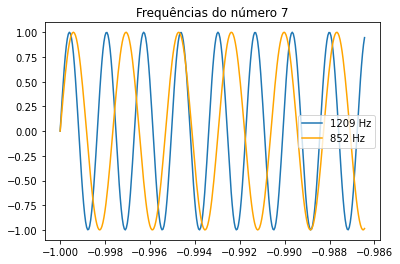

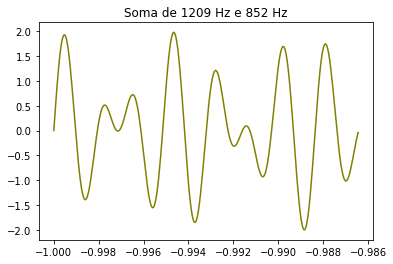

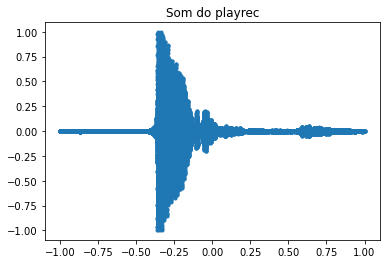

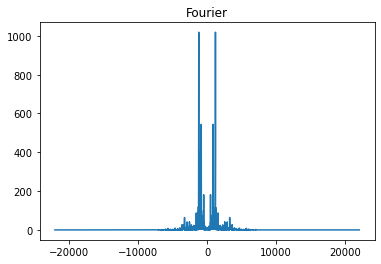

Frequencias de pico: -1221.5276990407947
Frequencias de pico: -1208.5274042495294
Frequencias de pico: -1194.5270867820145
Frequencias de pico: -851.5193088278647
Frequencias de pico: -837.5189913603499
Frequencias de pico: 838.5190140365994
Frequencias de pico: 852.5193315041142
Frequencias de pico: 1195.527109458264
Frequencias de pico: 1209.5274269257789
Frequencias de pico: 1222.5277217170442
Frequência Coluna: 1209 Hz
Frequência Linha: 852 Hz
Digito recebido: 7


In [98]:
emissor()
receptor()

In [ ]:
file = open("freq.txt","r+")
file.truncate(0)
file.close() 